In [1]:
import argparse
import copy
import torch
import time
import numpy as np
np.set_printoptions(precision = 4)
import pickle

from datasets.dataset import _load_collection_real,_load_collection_syn
from models_utility.construct_models import _initialize_SMkernelhyp,_make_gpmodel
from utility.eval_metric import _evaluate_metric
import matplotlib.pyplot as plt

import random


#import matplotlib.pylab as pl
from matplotlib import rc
#rc('text', usetex=True)
rc('font', size=20)
rc('legend', fontsize=20)
#rc('text.latex', preamble=r'\usepackage{cmbright}')


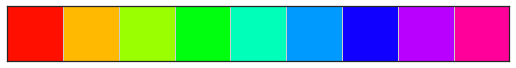

In [2]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(8+1, l=.5, s=1.0))

sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

# dataset

In [3]:
device = True

datafilename_list = ['CO2','airline','audio']


#filename = 'CO2'
filename = 'airline'
#filename = 'audio'



In [4]:
x_train, x_test, y_train, y_test = _load_collection_real(filename,cuda_option=device)


x_full = torch.cat([x_train,x_test],dim = 0)
y_full = torch.cat([y_train,y_test],dim = 0)
y_mean = y_full.mean()
y_train -= y_mean
y_test -= y_mean
y_full -= y_full.mean()
y_full = torch.cat([y_train,y_test],dim = 0)


#random_seed = 1000
random_seed = 1000
setting_dict = {}
setting_dict['random_seed'] = random_seed
setting_dict['input_dim'] = x_train.shape[1]




if filename in [ 'CO2']:
    print('C02 setting') 
    setting_dict['init_sample_num'] = 500    
    #setting_dict['lr_hyp'] = 0.01
    setting_dict['lr_hyp'] = 0.005 
    #setting_dict['noise_err'] = .05*y_train.cpu().data.numpy().std()
    setting_dict['noise_err'] = .1*y_train.cpu().data.numpy().std()
    
    setting_dict['Num_Q'] = 10
    setting_dict['num_sample_pt'] = 5
    setting_dict['iter'] = 4000
    setting_dict['weight_rate'] = 1.0  #allocation rate
    
    
elif filename in ['airline']:
    print('airline setting') 
    setting_dict['init_sample_num'] = 500    
    setting_dict['lr_hyp'] = 0.005 # 0.005 default
    setting_dict['noise_err'] = .05*y_train.cpu().data.numpy().std()
    setting_dict['Num_Q'] = 6
    setting_dict['num_sample_pt'] = 4
    setting_dict['iter'] = 4000
    setting_dict['weight_rate'] = 0.1 #allocation rate


elif filename in ['audio']:
    print('audio setting') 
    setting_dict['init_sample_num'] = 500    
    setting_dict['lr_hyp'] = 0.005
    setting_dict['noise_err'] = 1.0
    setting_dict['Num_Q'] = 8
    setting_dict['num_sample_pt'] = 5
    setting_dict['iter'] = 4000
    setting_dict['weight_rate'] = 1.0
else:
    pass


setting_dict['kl_option'] = True    #['True','False']
setting_dict['num_batch'] = 1
#setting_dict['tau0'] = 100
setting_dict['num_rep'] = 1
setting_dict['optimizer'] = 'Adam'





#loaded collection#
airline setting


In [5]:
result_dict = {}
result_dict['Exp_setting'] = setting_dict
result_dict['Data_setting'] = {'x_train' : x_train.cpu().data.numpy(),
                               'y_train' : y_train.cpu().data.numpy(),
                               'x_test' : x_test.cpu().data.numpy(),
                               'y_test' : y_test.cpu().data.numpy()}

result_dict['loss'] = {}
result_dict['rmse'] = {}
result_dict['mnll'] = {}
result_dict['best_loss'] = {}
result_dict['best_rmse'] = {}
result_dict['best_mnll'] = {}

result_dict['pred_train_mu'] = {}
result_dict['pred_train_var'] = {}
result_dict['pred_test_mu'] = {}
result_dict['pred_test_var'] = {}
result_dict['param_history'] = {}
result_dict['error_history'] = {}




### modelsetup

In [6]:
def _clone_parms(ith_model):
    if hasattr(ith_model,'kernel'):
        weight_ = ith_model.kernel.weight.data.clone()
        mu_ = ith_model.kernel.mu.data.clone()
        std_ = ith_model.kernel.std.data.clone()
        var_ = ith_model.likelihood.variance.data.clone()
    return weight_,mu_,std_,var_

def _transfer_params(model_reg,weight_,mu_,std_,var_):
    model_reg.weight.data = weight_
    model_reg.mu.data = mu_
    model_reg.std.data = std_
    model_reg.likelihood.variance.data = var_
    return model_reg

### proposed 

In [7]:
#setting_dict['iter']= 2000
#observed_period = 100
observed_period = 200

In [8]:
num_spt1 = 4

In [9]:
import torch.nn.utils as torch_utils
from scipy.linalg import norm as fnorm
from models_utility.personalized_adam import Adam_variation


def _train_model(ith_model_name,ith,setting_dict,num_spt1 ):
    setting_dict['num_sample_pt'] = num_spt1     
    if num_spt1 >= 2:
        # intializatoin part
        best_loss = np.inf
        for ith in range(5):    
            setting_dict = _initialize_SMkernelhyp(x_train, y_train, setting_dict, random_seed + ith ,yesSM= True, filename = filename)        

            temp_model = _make_gpmodel(model_name=ith_model_name, setting_dict=setting_dict, device=device)
            if ith_model_name in ['gpvfe', 'gpvferbf']:
                temp_model._set_data(batch_x=x_train, batch_y=y_train)        
                temp_model._set_inducing_pt(2 * setting_dict['Num_Q'] * setting_dict['num_sample_pt'])
                optimizable_param =  [*temp_model.parameters(),temp_model.likelihood.variance]
            elif ith_model_name in ['vssgp']:
                temp_model._set_data(batch_x=x_train, batch_y=y_train)                
                temp_model._set_inducing_pt( setting_dict['Num_Q'] * setting_dict['num_sample_pt'])
                optimizable_param =  [*temp_model.parameters()]
            else:
                temp_model._set_data(x_train, y_train)                            
                optimizable_param =  [*temp_model.parameters(),temp_model.likelihood.variance]

                
            temp_optimizer = torch.optim.Adam(optimizable_param ,
                                              lr=setting_dict['lr_hyp'],
                                              betas=(0.9, 0.99),
                                              eps=1e-08,
                                              weight_decay=0.0)    

            for i in range(1 + 1):    
                temp_optimizer.zero_grad()    
                #losstotal = temp_model.compute_loss(batch_x=x_train[::2], batch_y=y_train[::2], kl_option=setting_dict['kl_option'])
                losstotal = temp_model.compute_loss(batch_x=x_train, batch_y=y_train, kl_option=setting_dict['kl_option'])
                losstotal.backward()
                temp_optimizer.step()

            # best model chosen
            if best_loss >= losstotal.cpu().data.numpy():
                best_loss = losstotal.cpu().data.numpy()        
                ith_model = temp_model
                optimizer = temp_optimizer
                print('%d init loss: %.4f '%(ith,losstotal.cpu().data.numpy()))
                print('%d model chosen '%(ith))
            else:
                pass



        param_history_list = []
        error_history_list1,error_history_list2 = [],[]
        loss_history_list,loss_history_list1,loss_history_list2 = [],[],[]
        rmse_history_list,rmse_history_list1,rmse_history_list2 = [],[],[]

        print('#'*100)
        print(ith_model_name)
        ith_model.train()
        for i in range(setting_dict['iter'] + 1):
            optimizer.zero_grad()

            ith_tic = time.time()
            losstotal = ith_model.compute_loss(batch_x=x_train, batch_y=y_train, kl_option=setting_dict['kl_option'])
            losstotal.backward()
            optimizer.step()
            ith_toc = time.time()

            with torch.no_grad():
                pred_train_mu, pred_train_var = ith_model._predict(inputs_new=x_train)
                pred_test_mu, pred_test_var = ith_model._predict(inputs_new=x_test)        
                ith_rmse,ith_mnll = _evaluate_metric(pred_test_mu, pred_test_var, y_test)

            #print('\n')

            if i % observed_period == 0 :
                print('%d th loss0 : %.4f, test rmse : %.4f, test mnll: : %.4f' % (i,losstotal.cpu().data.numpy(),ith_rmse,ith_mnll))        
                #print('%d th loss0 : %.4f, reg0 : %.4f, test rmse : %.4f, test mnll: : %.4f' % (i,ith_loss.cpu().data.numpy(),ith_reg.cpu().data.numpy(),ith_rmse,ith_mnll))
                try:
                    print('self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance')            
                    print(ith_model.weight.exp().squeeze(),ith_model.mu.exp().squeeze(),ith_model.std.exp().squeeze(),ith_model.likelihood.variance.transform()**2)
                    print('\n')
                    print('self.num_samplept_list_at')
                    print(ith_model.num_samplept_list_at)

                except:
                    print('self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance')            
                    print(ith_model.kernel.weight.exp().squeeze(),ith_model.kernel.mu.exp().squeeze(),ith_model.kernel.std.exp().squeeze(),ith_model.likelihood.variance.transform()**2)
                    print('\n')
                    pass


                loss_history_list.append( losstotal.cpu().data.numpy().squeeze())
                rmse_history_list.append(ith_rmse.squeeze())



        return ith_model,loss_history_list,rmse_history_list
    else:
        return ith_model,loss_history_list,rmse_history_list
        



In [10]:
def _compare_reg_model(num_spt1):
    rep_loss_history_list_e,rep_loss_history_list_w = [],[]
    rep_rmse_history_list_e,rep_rmse_history_list_w = [],[]
    rep_model_history_list_e,rep_model_history_list_w = [],[]

    for i in range(3):
        model_w,loss_history_list_w,rmse_history_list_w =  _train_model('weight_reg',i,setting_dict,num_spt1=num_spt1)    
        model_e,loss_history_list_e,rmse_history_list_e =  _train_model('equal_reg',i,setting_dict,num_spt1=num_spt1)

        rep_loss_history_list_e.append(loss_history_list_e)
        rep_loss_history_list_w.append(loss_history_list_w)
        rep_rmse_history_list_e.append(rmse_history_list_e)
        rep_rmse_history_list_w.append(rmse_history_list_w)

        rep_model_history_list_e.append(model_e)
        rep_model_history_list_w.append(model_w)
        
    return rep_loss_history_list_e,rep_loss_history_list_w,\
           rep_rmse_history_list_e,rep_rmse_history_list_w,\
           rep_model_history_list_e,rep_model_history_list_w 

In [11]:
rep_loss_history_list_e,rep_loss_history_list_w,rep_rmse_history_list_e,rep_rmse_history_list_w,rep_model_history_list_e,rep_model_history_list_w =  _compare_reg_model(num_spt1 )


0 init loss: 21992.0170 
0 model chosen 
1 init loss: 20274.2417 
1 model chosen 
4 init loss: 14308.2728 
4 model chosen 
####################################################################################################
weight_reg
0 th loss0 : 16921.3525, test rmse : 192.8854, test mnll: : 1113.4315
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.0149, 1.0147, 1.0151, 1.0151, 1.0150, 1.0151], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0114, 0.2401, 0.0829, 0.4474, 0.1614, 0.3264], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0053, 0.0120, 0.0069, 0.0275, 0.0103, 0.0050], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([13.1543], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[3, 4, 3, 7, 4, 3]
200 th loss0 : 4055.2394, test rmse : 133.4803, test mnll: : 172.9730
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([2.3055, 2.0657, 2.2615, 1.8304, 2.2011, 2.1627], d

2800 th loss0 : 450.3531, test rmse : 47.4952, test mnll: : 6.1835
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([6.9917e+03, 1.7860e+01, 8.1915e+02, 1.1337e-02, 8.8658e-01, 1.6091e-01],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0026, 0.1015, 0.0824, 0.3691, 0.2801, 0.3215], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0005, 0.0876, 0.0022, 0.1000, 0.1115, 0.1026], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([326.6491], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[4, 5, 9, 2, 2, 2]
3000 th loss0 : 449.5341, test rmse : 46.7473, test mnll: : 6.1374
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.0648e+04, 1.7381e+01, 8.1490e+02, 7.3780e-03, 9.6463e-01, 1.1828e-01],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0024, 0.1142, 0.0830, 0.3669, 0.2801, 0.3200], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0005, 0.0961, 0.0022, 

1400 th loss0 : 578.0723, test rmse : 151.6597, test mnll: : 6.9736
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([ 8.0891, 24.5404, 16.6301,  2.3040,  2.9200,  0.9238], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.2561, 0.0037, 0.0838, 0.2462, 0.3038, 0.2334], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0310, 0.0028, 0.0057, 0.0986, 0.0795, 0.1006], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([7040.2246], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[4, 4, 4, 4, 4, 4]
1600 th loss0 : 570.7176, test rmse : 150.5476, test mnll: : 7.0350
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([ 5.9262, 45.0506, 17.9486,  1.6641,  1.9155,  0.6613], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.3316, 0.0034, 0.0851, 0.2394, 0.3075, 0.2321], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0736, 0.0027, 0.0146, 0.0995, 0.1001, 0.1009], device='

200 th loss0 : 4263.2173, test rmse : 146.1275, test mnll: : 202.9151
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([2.2913, 1.9932, 2.2300, 1.7167, 2.2337, 2.1362], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0070, 0.2469, 0.0838, 0.4357, 0.1689, 0.3323], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0058, 0.0113, 0.0046, 0.0275, 0.0071, 0.0031], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([44.1074], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[2, 5, 3, 7, 4, 3]
400 th loss0 : 3797.6630, test rmse : 134.4114, test mnll: : 70.5797
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([4.0540, 3.1981, 3.9546, 1.9635, 3.9263, 3.6423], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0056, 0.2471, 0.0829, 0.4279, 0.1685, 0.3323], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0046, 0.0101, 0.0035, 0.0292, 0.0053, 0.0025], device='cuda:0',
  

3200 th loss0 : 449.8371, test rmse : 43.1532, test mnll: : 5.6378
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.3880e+04, 1.4261e+01, 8.4176e+02, 3.5196e-03, 6.2902e-01, 7.2085e-02],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0023, 0.0946, 0.0827, 0.3696, 0.2990, 0.3204], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0006, 0.0826, 0.0022, 0.1002, 0.1029, 0.0997], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([331.4286], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[6, 4, 8, 2, 2, 2]
3400 th loss0 : 449.0365, test rmse : 44.7527, test mnll: : 5.4929
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.5376e+04, 1.4734e+01, 8.4037e+02, 2.5368e-03, 5.0436e-01, 5.5013e-02],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0023, 0.0942, 0.0828, 0.3693, 0.3079, 0.3183], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0006, 0.0800, 0.0021, 

1800 th loss0 : 526.7553, test rmse : 86.2639, test mnll: : 6.7651
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([  2.9606, 163.0901,  22.8581,   1.2681,   0.9304,   0.4083],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.3246, 0.0041, 0.0774, 0.2377, 0.3070, 0.2332], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.1033, 0.0016, 0.0341, 0.1010, 0.1020, 0.1021], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([1705.6793], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[4, 4, 4, 4, 4, 4]
2000 th loss0 : 496.0093, test rmse : 78.4553, test mnll: : 7.5836
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.1618e+00, 4.4486e+02, 5.5097e+01, 8.1291e-01, 3.9632e-01, 3.0060e-01],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.3342, 0.0037, 0.0800, 0.2368, 0.3112, 0.2404], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.1025, 0.0009, 0.0362, 0.0996, 0.0

400 th loss0 : 2753.4748, test rmse : 164.7632, test mnll: : 107.1494
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([4.1528, 3.4040, 3.8980, 1.8603, 3.8834, 3.7229], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0055, 0.2513, 0.0847, 0.4314, 0.1674, 0.3307], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0051, 0.0075, 0.0033, 0.0312, 0.0056, 0.0028], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([116.4479], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[3, 4, 3, 7, 4, 3]
600 th loss0 : 1269.7124, test rmse : 141.6665, test mnll: : 36.0589
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([7.0067, 4.8133, 6.3109, 1.5183, 6.1260, 5.5757], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0047, 0.2460, 0.0842, 0.4142, 0.1681, 0.3325], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0040, 0.0069, 0.0026, 0.0372, 0.0045, 0.0028], device='cuda:0',
 

3400 th loss0 : 447.3179, test rmse : 45.0688, test mnll: : 5.6435
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.4992e+04, 1.6835e+01, 8.9220e+02, 3.5999e-03, 5.4908e-01, 8.7357e-02],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0023, 0.1107, 0.0834, 0.3713, 0.3201, 0.3289], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0006, 0.1130, 0.0022, 0.0990, 0.0908, 0.0962], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([317.6143], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[6, 4, 8, 2, 2, 2]
3600 th loss0 : 448.5380, test rmse : 44.6282, test mnll: : 5.5898
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.5401e+04, 1.6389e+01, 8.7032e+02, 2.7584e-03, 4.3177e-01, 6.9032e-02],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0023, 0.0973, 0.0835, 0.3692, 0.3100, 0.3195], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0007, 0.0996, 0.0022, 

2000 th loss0 : 507.1004, test rmse : 87.4069, test mnll: : 7.9906
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([3.8541e+02, 6.5004e+00, 1.5090e+01, 5.8053e-02, 1.2558e+00, 3.4408e-01],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0037, 0.1044, 0.1551, 0.3696, 0.2976, 0.3190], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0010, 0.1015, 0.0511, 0.0999, 0.1002, 0.1017], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([953.3527], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[4, 4, 4, 4, 4, 4]
2200 th loss0 : 492.8097, test rmse : 77.5927, test mnll: : 7.3394
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([8.0750e+02, 1.0931e+01, 2.0772e+01, 2.9927e-02, 7.6476e-01, 2.1700e-01],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0034, 0.1034, 0.1398, 0.3702, 0.3013, 0.3110], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0008, 0.0894, 0.0579, 

### summary

In [12]:
wl_mean1,wl_std1 = np.asarray(rep_loss_history_list_w).mean(axis = 0).round(3), np.asarray(rep_loss_history_list_w).std(axis = 0).round(3)
el_mean1,el_std1 = np.asarray(rep_loss_history_list_e).mean(axis = 0).round(3), np.asarray(rep_loss_history_list_e).std(axis = 0).round(3)


wr_mean1,wr_std1 = np.asarray(rep_rmse_history_list_w).mean(axis = 0).round(3), np.asarray(rep_rmse_history_list_w).std(axis = 0).round(3)
er_mean1,er_std1 = np.asarray(rep_rmse_history_list_e).mean(axis = 0).round(3), np.asarray(rep_rmse_history_list_e).std(axis = 0).round(3)



In [13]:
np.arange(5,10)

array([5, 6, 7, 8, 9])

In [14]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'stix:italic'
#plt.rc('font', weight='bold')

# current_palette = sns.color_palette(sns.hls_palette(8+1, l=.5, s=1.0))
# sns.palplot(current_palette)
# current_palette = np.asarray(current_palette)

In [15]:
figsiz = (7,5)
#figsiz = (5,3.5)

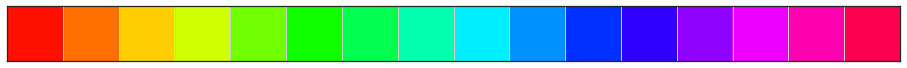

In [16]:
current_palette = sns.color_palette(sns.hls_palette(15+1, l=.5, s=1.0))
sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

In [17]:
figsiz = (7,5)
markersiz = 8
#figsiz = (5,3.5)

### loss

In [18]:
save_figname = filename + '_loss'+ '_Q'+str(setting_dict['Num_Q']) + '_spt' + str(num_spt1) + '_esti'
save_figname

'airline_loss_Q6_spt4_esti'

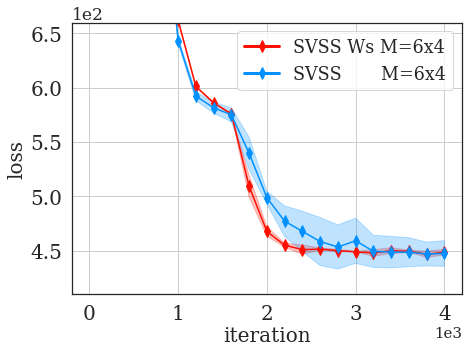

In [19]:
idx = observed_period*np.arange(len(wl_mean1))

plt.figure(figsize = figsiz)

idxh = 0
plt.plot(idx, wl_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz,label = 'SVSS Ws M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1))
plt.fill_between( idx,
                  wl_mean1 - wl_std1,
                  wl_mean1 + wl_std1,
                  alpha = 0.25, edgecolor = current_palette[idxh], facecolor =  current_palette[idxh])



idxh = 9
plt.plot(idx,el_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz,label = 'SVSS' '       M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1))
plt.fill_between( idx,
                  el_mean1 - el_std1,
                  el_mean1 + el_std1,
                  alpha = 0.25, edgecolor = current_palette[idxh], facecolor =  current_palette[idxh])



plt.xlabel('iteration',fontsize = 20)
plt.ylabel('loss',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))


plt.ylim([.41*1e3,.66*1e3]) #airline





leg = plt.legend(loc='best', fontsize = 17.5)

for line in leg.get_lines():
    line.set_linewidth(3) 
plt.gca().yaxis.get_offset_text().set_size(17)
plt.gca().xaxis.get_offset_text().set_size(15)

plt.show()




### rmse

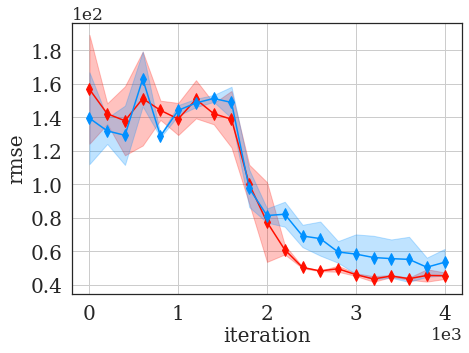

In [20]:
idx = observed_period*np.arange(len(wl_mean1))
plt.figure(figsize = figsiz)

idxh = 0
plt.plot(idx,wr_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz,label = 'weight M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1))
plt.fill_between( idx,
                  wr_mean1 - wr_std1,
                  wr_mean1 + wr_std1,
                  alpha = 0.25, edgecolor = current_palette[idxh], facecolor =  current_palette[idxh])




idxh = 9
plt.plot(idx,er_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz,label = 'equal M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1))
plt.fill_between( idx,
                  er_mean1 - er_std1,
                  er_mean1 + er_std1,
                  alpha = 0.25, edgecolor = current_palette[idxh], facecolor =  current_palette[idxh])





plt.xlabel('iteration',fontsize = 20)
plt.ylabel('rmse',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=6)
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_size(17)
plt.gca().xaxis.get_offset_text().set_size(17)




plt.show()




In [35]:
idx = 1

# weight sampling

In [36]:
ith_model = rep_model_history_list_w[idx]

In [37]:
with torch.no_grad():
    pred_train_mu, pred_train_var = ith_model._predict_exact(inputs_new=x_train)
    pred_test_mu, pred_test_var = ith_model._predict_exact(inputs_new=x_test)


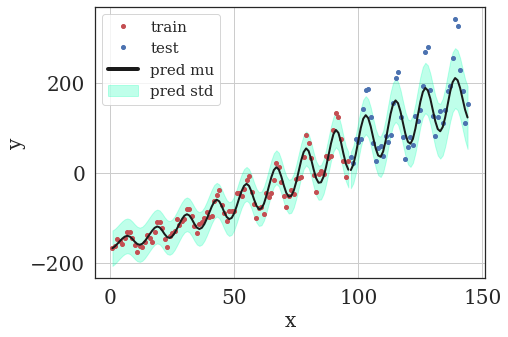

In [38]:
figsiz = (7,5)

ith = 7
plt.figure(figsize = figsiz)


plt.plot(x_train.cpu().data.numpy().squeeze(),y_train.cpu().data.numpy().squeeze(),'r.',markersize = 8, label='train')
plt.plot(x_test.cpu().data.numpy().squeeze(),y_test.cpu().data.numpy().squeeze(),'b.',markersize = 8, label='test')

plt.plot(x_train.cpu().data.numpy().squeeze(),pred_train_mu.cpu().data.numpy().squeeze(),'k',linewidth = 2, label='pred mu')

plt.fill_between( x_train.cpu().data.numpy().squeeze(),
                  pred_train_mu.cpu().data.numpy().squeeze() + 2*pred_train_var.sqrt().cpu().data.numpy().squeeze(),
                  pred_train_mu.cpu().data.numpy().squeeze() - 2*pred_train_var.sqrt().cpu().data.numpy().squeeze(),
                  alpha = 0.25, edgecolor = current_palette[ith], facecolor =  current_palette[ith], label='pred std')

plt.plot(x_test.cpu().data.numpy().squeeze(),pred_test_mu.cpu().data.numpy().squeeze() ,'k',linewidth = 2)
plt.fill_between( x_test.cpu().data.numpy().squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() + 2*pred_test_var.sqrt().cpu().data.numpy().squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() - 2*pred_test_var.sqrt().cpu().data.numpy().squeeze(),
                  alpha = 0.25, edgecolor = current_palette[ith], facecolor =  current_palette[ith])



plt.xlabel('x',fontsize = 20)
plt.ylabel('y',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)



leg = plt.legend(loc='best', fontsize = 15)
for line in leg.get_lines():
    line.set_linewidth(4) 
    line.set_markersize(4) 

plt.show()
# plt.plot(x_full.cpu().data.numpy().squeeze(),prede_test_mu.cpu().data.numpy().squeeze() + 2*prede_test_var.sqrt().cpu().data.numpy().squeeze() ,'g')
# plt.plot(x_full.cpu().data.numpy().squeeze(),prede_test_mu.cpu().data.numpy().squeeze(),'g')
# plt.plot(x_full.cpu().data.numpy().squeeze(),prede_test_mu.cpu().data.numpy().squeeze() - 2*prede_test_var.sqrt().cpu().data.numpy().squeeze() ,'g')


# equal sampling

In [39]:
ith_model = rep_model_history_list_e[idx]

In [40]:
with torch.no_grad():
    pred_train_mu, pred_train_var = ith_model._predict_exact(inputs_new=x_train)
    pred_test_mu, pred_test_var = ith_model._predict_exact(inputs_new=x_test)


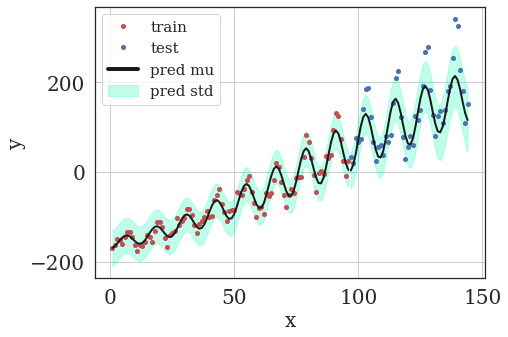

In [41]:
figsiz = (7,5)

ith = 7
plt.figure(figsize = figsiz)


plt.plot(x_train.cpu().data.numpy().squeeze(),y_train.cpu().data.numpy().squeeze(),'r.',markersize = 8, label='train')
plt.plot(x_test.cpu().data.numpy().squeeze(),y_test.cpu().data.numpy().squeeze(),'b.',markersize = 8, label='test')

plt.plot(x_train.cpu().data.numpy().squeeze(),pred_train_mu.cpu().data.numpy().squeeze(),'k',linewidth = 2, label='pred mu')

plt.fill_between( x_train.cpu().data.numpy().squeeze(),
                  pred_train_mu.cpu().data.numpy().squeeze() + 2*pred_train_var.sqrt().cpu().data.numpy().squeeze(),
                  pred_train_mu.cpu().data.numpy().squeeze() - 2*pred_train_var.sqrt().cpu().data.numpy().squeeze(),
                  alpha = 0.25, edgecolor = current_palette[ith], facecolor =  current_palette[ith], label='pred std')

plt.plot(x_test.cpu().data.numpy().squeeze(),pred_test_mu.cpu().data.numpy().squeeze() ,'k',linewidth = 2)
plt.fill_between( x_test.cpu().data.numpy().squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() + 2*pred_test_var.sqrt().cpu().data.numpy().squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() - 2*pred_test_var.sqrt().cpu().data.numpy().squeeze(),
                  alpha = 0.25, edgecolor = current_palette[ith], facecolor =  current_palette[ith])



plt.xlabel('x',fontsize = 20)
plt.ylabel('y',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)



leg = plt.legend(loc='best', fontsize = 15)
for line in leg.get_lines():
    line.set_linewidth(4) 
    line.set_markersize(4) 

plt.show()
# plt.plot(x_full.cpu().data.numpy().squeeze(),prede_test_mu.cpu().data.numpy().squeeze() + 2*prede_test_var.sqrt().cpu().data.numpy().squeeze() ,'g')
# plt.plot(x_full.cpu().data.numpy().squeeze(),prede_test_mu.cpu().data.numpy().squeeze(),'g')
# plt.plot(x_full.cpu().data.numpy().squeeze(),prede_test_mu.cpu().data.numpy().squeeze() - 2*prede_test_var.sqrt().cpu().data.numpy().squeeze() ,'g')
